In [1]:
import pandas as pd
import numpy as np
df = pd.read_excel(r"G:\My Drive\Ingegneria\Data Science GD\Models\NLP\BERT Multiclass TF\commentstopics.xlsx")
df.head()

,Unnamed: 0,Descrizione commento,Topic,Name
0,0,Libro consigliato a tutti coloro che vogliono ...,130,traduzione traducibilità testo cantos
1,1,"Appassionante, anche se ho avuto l'impressione...",130,traduzione traducibilità testo cantos
2,2,Antologia che comprende molti dei cantos più n...,130,traduzione traducibilità testo cantos
3,3,Letto con interesse. Particolarmente degna di ...,130,traduzione traducibilità testo cantos
4,4,"Non mi ha appassionato, ma bene che ci sia il ...",130,traduzione traducibilità testo cantos


In [2]:
pd.set_option('display.max_rows', None)

df[['Name', 'Topic']].value_counts()[:10]

Name                                    Topic
  film regista un attori                0        1255
  mi libro ho libri                     1        1096
  bambini libro disegni bambino         2         545
  donne donna femminile le              3         290
  commissario omicidio il una           4         232
  bello bellissimo molto interessante   5         203
  amore storia due che                  6         171
  giapponese giappone giapponesi tokyo  7         164
  russia russa russi russo              8         156
  lei padre madre una                   9         153
Name: count, dtype: int64

In [3]:
df_traintestval = df[df['Topic'].isin([0,2,3,4,6])][['Descrizione commento', 'Name']].rename(columns={'Descrizione commento': 'Text', 'Name': 'Topic Description'}).reset_index(drop=True)

df_traintestval.head()

,Text,Topic Description
0,"""Una persona seduta davanti a un tavolo con lo...",donne donna femminile le
1,..molto strano.\nStrano per come mi è arrivato...,donne donna femminile le
2,Finalmente anche gli uomini si accorgono di un...,donne donna femminile le
3,Dieci donne ricoverate nel reparto di maternit...,donne donna femminile le
4,"Uomo e donna, maschio e femmina, maschile e fe...",donne donna femminile le


In [4]:

def split_stratify(df, perc):
    df1 = pd.DataFrame()
    df2 = pd.DataFrame()
    name_topics = df['Topic Description'].unique()
    for topic in name_topics:
        perc_df_per_topic = int(len(df[df['Topic Description']==topic])*perc)
        df1 = pd.concat([df1, df[df['Topic Description']==topic][:perc_df_per_topic]])
        df2 = pd.concat([df2, df[df['Topic Description']==topic][perc_df_per_topic:]])
    return df1, df2


In [5]:
df_traintest, df_val = split_stratify(df_traintestval,0.8)
df_traintest.shape, df_val.shape

((1993, 2), (500, 2))

In [6]:
df_traintest['Topic Description'].value_counts()

Topic Description
  film regista un attori           1004
  bambini libro disegni bambino     436
  donne donna femminile le          232
  commissario omicidio il una       185
  amore storia due che              136
Name: count, dtype: int64

In [7]:
df_val['Topic Description'].value_counts()

Topic Description
  film regista un attori           251
  bambini libro disegni bambino    109
  donne donna femminile le          58
  commissario omicidio il una       47
  amore storia due che              35
Name: count, dtype: int64

In [8]:
df_traintest['Topic Description'].value_counts(normalize = True)

Topic Description
  film regista un attori           0.503763
  bambini libro disegni bambino    0.218766
  donne donna femminile le         0.116407
  commissario omicidio il una      0.092825
  amore storia due che             0.068239
Name: proportion, dtype: float64

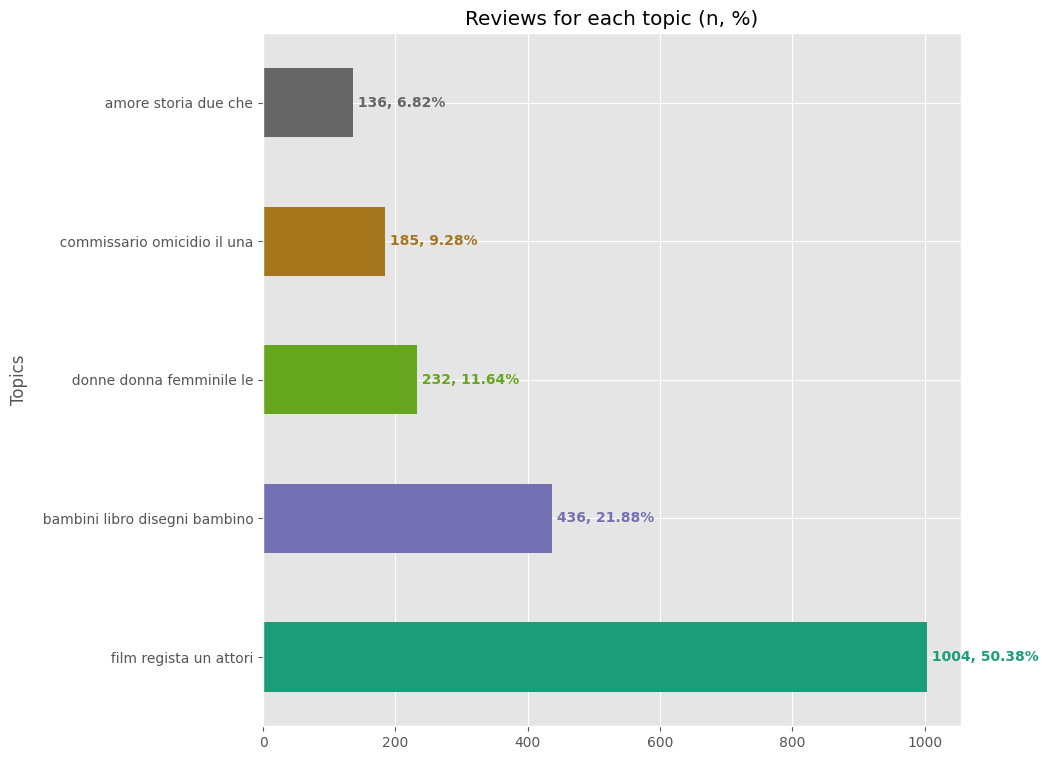

In [9]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')


num_classes = len(df_traintest["Topic Description"].value_counts())
colors = plt.cm.Dark2(np.linspace(0, 1, num_classes))
iter_color = iter(colors)

df_traintest['Topic Description'].value_counts().plot.barh(title="Reviews for each topic (n, %)", 
                                                 ylabel="Topics",
                                                 color=colors,
                                                 figsize=(9,9))

for i, v in enumerate(df_traintest['Topic Description'].value_counts()):
    c = next(iter_color)
    plt.text(v, i,
           " "+str(v)+", "+str(round(v*100/df_traintest.shape[0],2))+"%", 
           color=c, 
           va='center', 
           fontweight='bold')

In [10]:
df_traintest.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1993 entries, 0 to 2445
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Text               1993 non-null   object
 1   Topic Description  1993 non-null   object
dtypes: object(2)
memory usage: 46.7+ KB


In [11]:
# map topic descriptions to labels
df_traintest['Topic Description'] = df_traintest['Topic Description'].str.strip()
df_traintest['Labels'] = df_traintest['Topic Description'].map({'film regista un attori': 0,
                                            'bambini libro disegni bambino': 1,
                                            'donne donna femminile le': 2,
                                            'commissario omicidio il una': 3,
                                            'amore storia due che': 4})

# drop unused column
df_traintest = df_traintest.drop(["Topic Description"], axis=1)

df_traintest.head()

,Text,Labels
0,"""Una persona seduta davanti a un tavolo con lo...",2
1,..molto strano.\nStrano per come mi è arrivato...,2
2,Finalmente anche gli uomini si accorgono di un...,2
3,Dieci donne ricoverate nel reparto di maternit...,2
4,"Uomo e donna, maschio e femmina, maschile e fe...",2


In [12]:
df_traintest.Labels.value_counts()

Labels
0    1004
1     436
2     232
3     185
4     136
Name: count, dtype: int64

In [13]:
# Inspect random samples

# for Colab users: !pip install translate
from translate import Translator
from termcolor import colored


translator= Translator(from_lang="it", to_lang="en")

def print_rand_example(df, col_name, col_value, chars=180):
    '''print a random review and its translation given a label
    Args:
    - df: input dataframe
    - col_name: column to use as filter (e.g. Label)
    - col_value: value of col_name to use as filter 
    - chars (optional, def:180) max number of characters to display
    '''
    original = df[df[col_name]==col_value].sample()["Text"].values[0]
    translation = translator.translate(original).replace("&#39;","'")
    print(colored("\nOriginal", 'green', attrs=['bold','underline']))
    print(original[0:chars] + "...")
    print(colored("\nTranslation", 'red', attrs=['bold','underline']))
    print(translation[0:chars] + "...")

In [14]:
print_rand_example(df_traintest, "Labels", 4)


Original
Libro in perfetto stile De Carlo. Grande passione nel lavoro più amore travolgente. ...

Translation
Book in perfect De Carlo style. Great passion in the most overwhelming love work....


In [15]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

y = tf.keras.utils.to_categorical(df_traintest["Labels"].values, num_classes=num_classes)
y


array([[0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

In [16]:
x_train, x_test, y_train, y_test = train_test_split(df_traintest['Text'], y, test_size=0.25)

In [17]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1494,), (499,), (1494, 5), (499, 5))

In [18]:
import tensorflow_hub as hub
import tensorflow_text as text

preprocessor = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-preprocess/2")
encoder = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-base/1")


def get_embeddings(sentences):
    '''return BERT-like embeddings of input text
    Args:
    - sentences: list of strings
    Output:
    - BERT-like embeddings: tf.Tensor of shape=(len(sentences), 768)
    '''
    preprocessed_text = preprocessor(sentences)
    return encoder(preprocessed_text)['pooled_output']


get_embeddings(["Questa collezione di Haiku è una porta aperta sulla cultura giapponese."])

<tf.Tensor: shape=(1, 768), dtype=float32, numpy=
array([[ 1.08269244e-01, -9.16296318e-02, -3.19652915e-01,
        -1.70696378e-02,  3.34133953e-01,  2.00266287e-01,
        -2.46935681e-01, -5.43310583e-01, -3.56956571e-01,
        -2.97796816e-01, -2.08980814e-01,  1.42026007e-01,
         2.72497833e-02, -4.33980972e-01, -5.73600054e-01,
        -8.82729232e-01,  2.37144127e-01, -1.87127918e-01,
        -2.56524146e-01, -2.46630058e-01,  6.32454634e-01,
         1.21354103e-01, -3.95606369e-01,  1.58426076e-01,
        -6.60165474e-02, -1.00859761e+00,  3.03425103e-01,
         2.40527783e-02, -9.84717607e-02, -6.36505425e-01,
         1.15401812e-01, -7.62529016e-01, -5.43886423e-01,
        -4.67391938e-01, -6.24043107e-01,  2.63593137e-01,
        -4.41221625e-01,  6.62034974e-02, -3.88788134e-01,
         1.61617324e-02,  1.15522988e-01, -4.35086876e-01,
        -5.12637496e-01,  2.74716765e-01, -3.44000936e-01,
        -1.88090324e-01,  1.52757270e-02, -3.23565990e-01,
      

In [19]:
# Observe semantic textual similarities

import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

def plot_similarity(features, labels):
    """Plot a similarity matrix of the embeddings."""
    cos_sim = cosine_similarity(features)
    fig = plt.figure(figsize=(10,8))
    sns.set(font_scale=1.2)
    cbar_kws=dict(use_gridspec=False, location="left") #  to customize the colorbar
    g = sns.heatmap(
      cos_sim, xticklabels=labels, yticklabels=labels,
      vmin=0, vmax=1, annot=True, cmap="Blues", 
      cbar_kws=cbar_kws)
    g.tick_params(labelright=True, labelleft=False)
    g.set_yticklabels(labels, rotation=0)
    g.set_title("Semantic Textual Similarity")

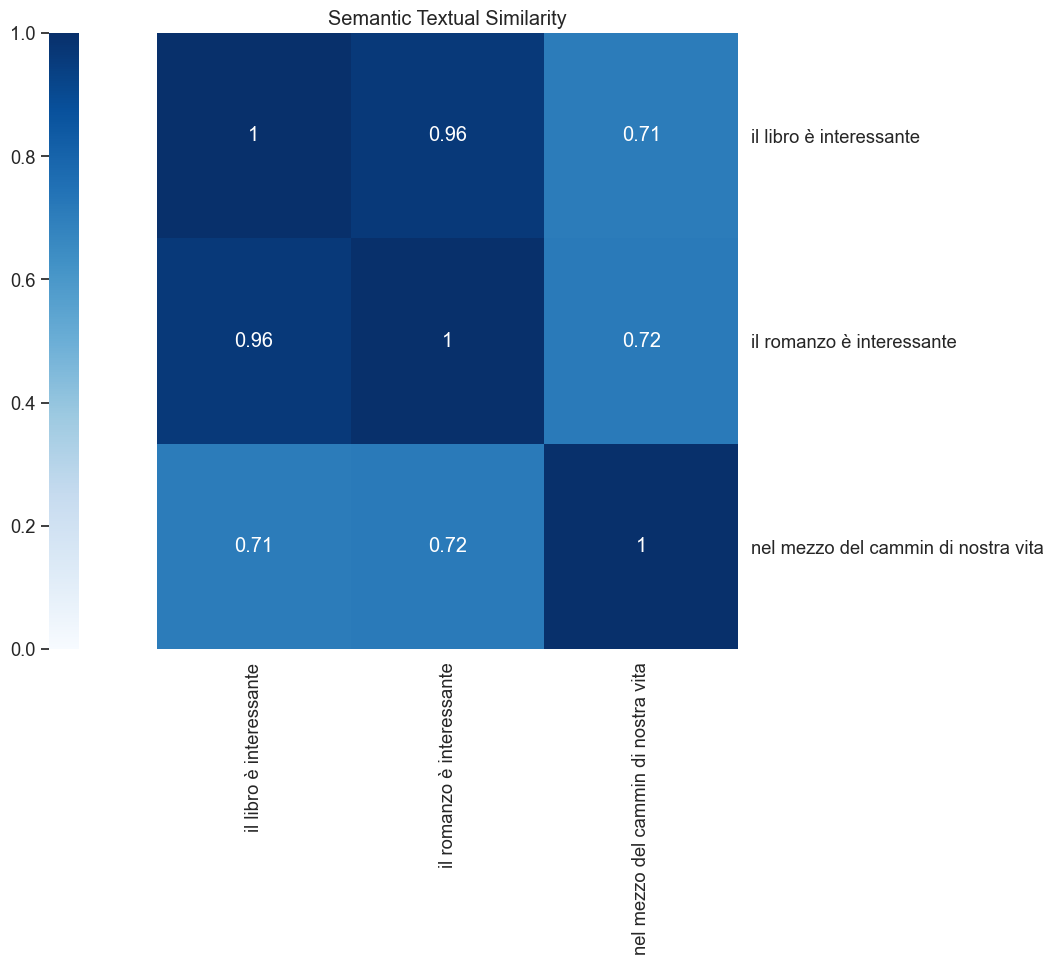

In [20]:
reviews = ["il libro è interessante",
           "il romanzo è interessante",
           "nel mezzo del cammin di nostra vita"]

plot_similarity(get_embeddings(reviews), reviews)

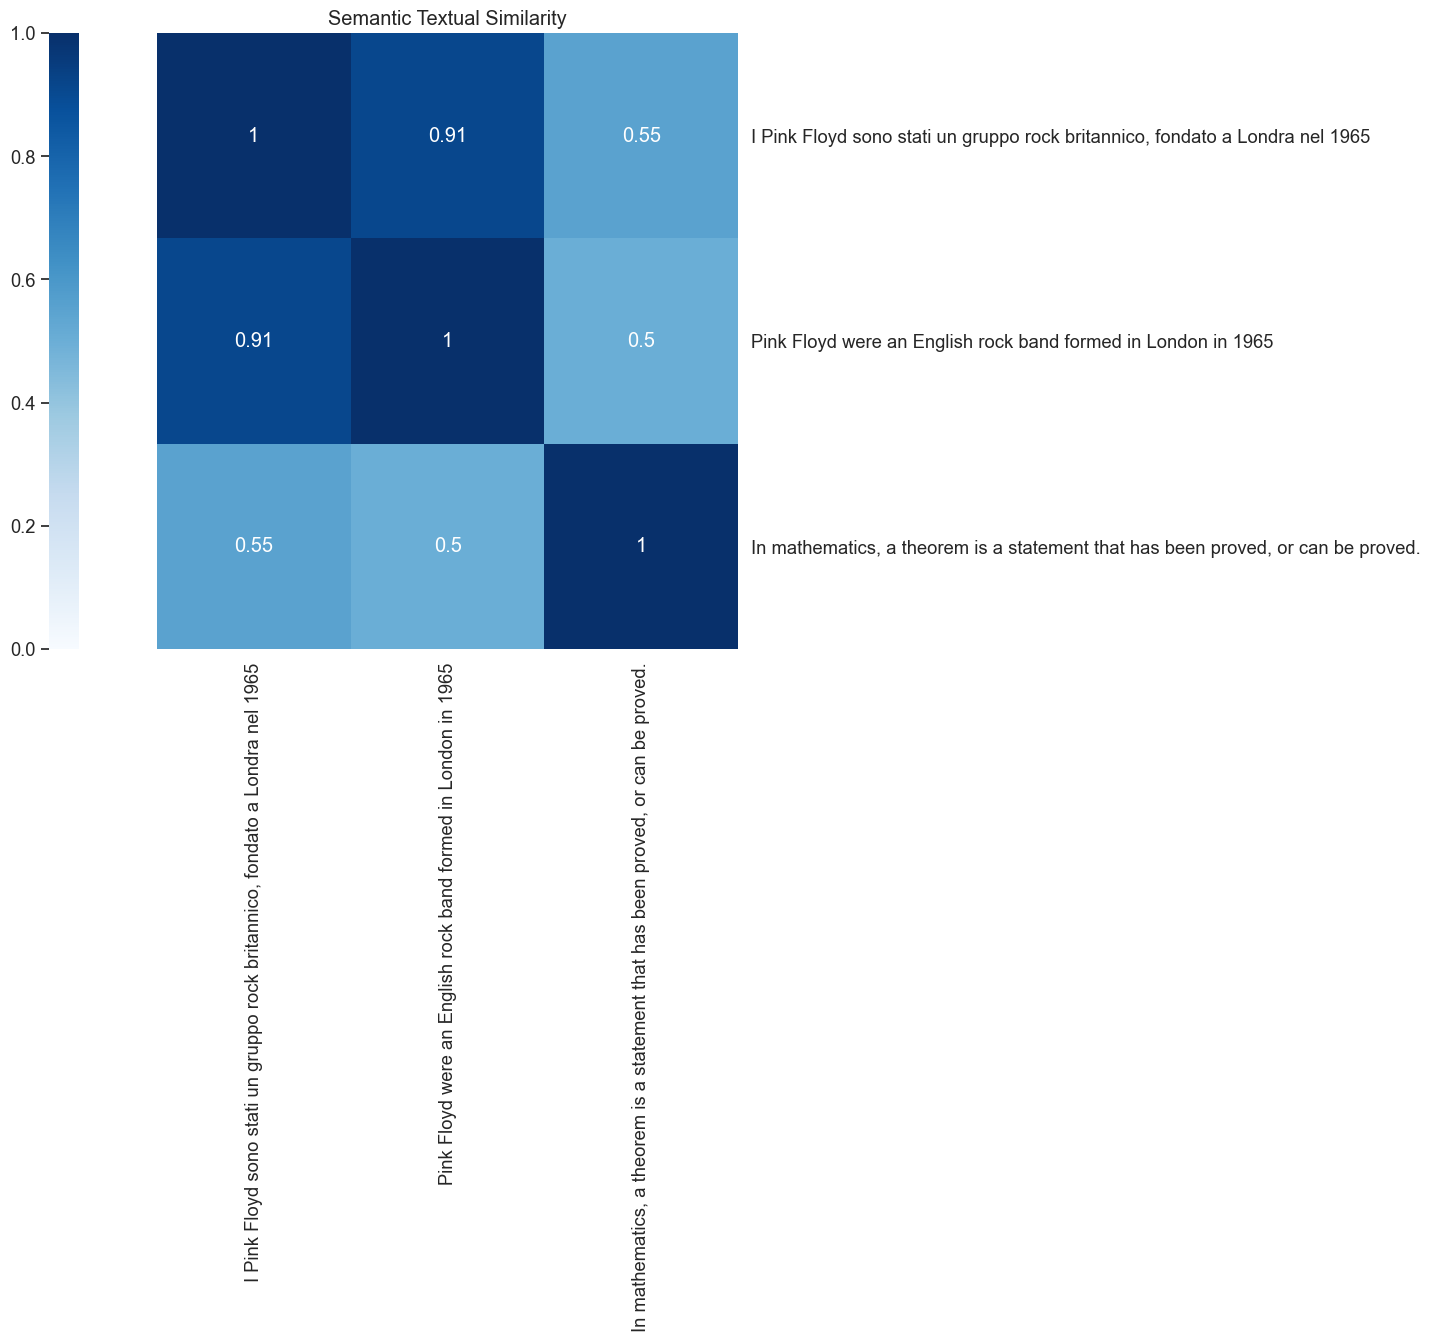

In [21]:
reviews = ["I Pink Floyd sono stati un gruppo rock britannico, fondato a Londra nel 1965",
           "Pink Floyd were an English rock band formed in London in 1965",
           "In mathematics, a theorem is a statement that has been proved, or can be proved."]

plot_similarity(get_embeddings(reviews), reviews)

In [22]:
y_train

array([[1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [23]:
from keras import backend as K

def balanced_recall(y_true, y_pred):
    """This function calculates the balanced recall metric
    recall = TP / (TP + FN)
    """
    recall_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true_class, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        recall_by_class = recall_by_class + recall
    return recall_by_class / y_pred.shape[1]

def balanced_precision(y_true, y_pred):
    """This function calculates the balanced precision metric
    precision = TP / (TP + FP)
    """
    precision_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred_class, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        precision_by_class = precision_by_class + precision
    # return average balanced metric for each class
    return precision_by_class / y_pred.shape[1]

def balanced_f1_score(y_true, y_pred):
    """This function calculates the F1 score metric"""
    precision = balanced_precision(y_true, y_pred)
    recall = balanced_recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [24]:
# We now define a model as the preprocessor and encoder layers followed by a dropout and a dense layer with a softmax activation function and an output space dimensionality equal to the number of classes we want to predict

i = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
# shape=() specifies that the input is a 0-dimensional tensor (a scalar), and dtype=tf.string specifies that the elements in this tensor are strings. So, each “scalar” in this context is a string.
# This is often used when you’re working with models that process text data. Each “scalar” string could be an entire document or sentence that the model will process.
# The input must be a single string. However, when training the model, you would typically pass in a batch of data at once for efficiency. This batch of data would be a 1-dimensional tensor (or vector) of strings, where each element in the vector is a single string (the individual input data points)
x = preprocessor(i)
x = encoder(x)
x = tf.keras.layers.Dropout(0.2, name="dropout")(x['pooled_output'])
x = tf.keras.layers.Dense(num_classes, activation='softmax', name="output")(x)

model = tf.keras.Model(i, x)
model

In [25]:
n_epochs = 20

METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
      balanced_recall,
      balanced_precision,
      balanced_f1_score
]

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                                      patience = 3,
                                                      restore_best_weights = True)
# if the metric does not improve for at least 3 epochs (patience = 3), the training is interrupted and the weights from the epoch where the validation loss showed the best value (i.e. lowest) are restored (restore_best_weights = True)
earlystop_callback


In [26]:
model.compile(optimizer = "adam",
              loss = "categorical_crossentropy",
              metrics = METRICS)
model


In [27]:
model_fit = model.fit(x_train, 
                      y_train, 
                      epochs = n_epochs,
                      validation_data = (x_test, y_test),
                      callbacks = [earlystop_callback])

Epoch 1/20
47/47 [==============================] - 41s 504ms/step - loss: 1.1461 - accuracy: 0.5703 - balanced_recall: 0.1923 - balanced_precision: 0.2572 - balanced_f1_score: 0.2115 - val_loss: 0.8697 - val_accuracy: 0.6653 - val_balanced_recall: 0.2845 - val_balanced_precision: 0.3671 - val_balanced_f1_score: 0.3194
Epoch 2/20
47/47 [==============================] - 21s 449ms/step - loss: 0.7385 - accuracy: 0.7550 - balanced_recall: 0.3355 - balanced_precision: 0.4577 - balanced_f1_score: 0.3845 - val_loss: 0.6197 - val_accuracy: 0.8156 - val_balanced_recall: 0.4194 - val_balanced_precision: 0.5910 - val_balanced_f1_score: 0.4885
Epoch 3/20
47/47 [==============================] - 22s 479ms/step - loss: 0.5562 - accuracy: 0.8440 - balanced_recall: 0.4563 - balanced_precision: 0.6422 - balanced_f1_score: 0.5306 - val_loss: 0.4830 - val_accuracy: 0.8778 - val_balanced_recall: 0.5574 - val_balanced_precision: 0.7277 - val_balanced_f1_score: 0.6278
Epoch 4/20
47/47 [===================

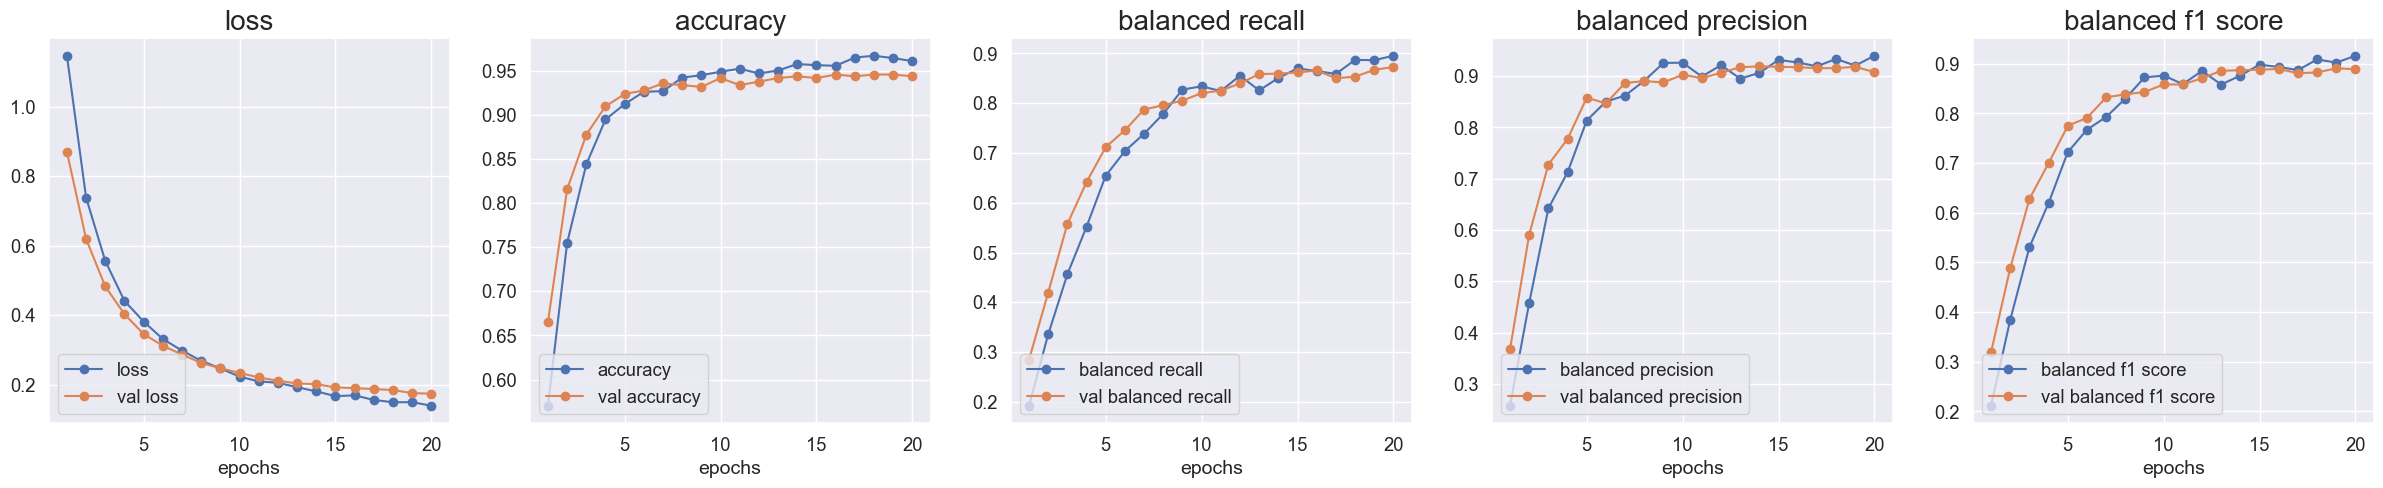

In [28]:
x = list(range(1, n_epochs+1))
metric_list = list(model_fit.history.keys())
num_metrics = int(len(metric_list)/2)

fig, ax = plt.subplots(nrows=1, ncols=num_metrics, figsize=(30, 5))

for i in range(0, num_metrics):
    ax[i].plot(x, model_fit.history[metric_list[i]], marker="o", label=metric_list[i].replace("_", " "))
    ax[i].plot(x, model_fit.history[metric_list[i+num_metrics]], marker="o", label=metric_list[i+num_metrics].replace("_", " "))
    ax[i].set_xlabel("epochs",fontsize=14)
    ax[i].set_title(metric_list[i].replace("_", " "),fontsize=20)
    ax[i].legend(loc="lower left")

In [31]:
# test prediction on some newly generated reviews
reviews = [
    "Questa collezione di Haiku è una porta aperta sulla cultura giapponese.",
    "Questo libro descrive l'emancipazione femminile nella cultura patriarcale.",
    "Questo trattato di economia moderna è il vademecum di qualsiasi appassionato di mercati finanziari.", # finance topic not present
    "mi ha fatto ricordare quando ero piccolo e giocavo con le macchinine tanti anni fa",
    "mi sono innamorato di questi versi!"
]

# observe translated samples
print([translator.translate(review).replace("&#39;","'") for review in reviews])

['This Haiku collection is an open door to Japanese culture.', 'This book describes female emancipation in patriarchal culture.', 'This treatise on modern economics is the handbook of any financial market enthusiast.', 'reminded me of when I was little and played with cars so many years ago', 'i fell in love with these verses!']


In [46]:
df_val['Labels'] = df_val['Topic Description'].str.strip().map({
    'film regista un attori': 0,
    'bambini libro disegni bambino': 1,
    'donne donna femminile le': 2,
    'commissario omicidio il una': 3,
    'amore storia due che': 4
})

In [47]:
def predict_class(reviews):
    '''predict class of input text
    Args:
    - reviews (list of strings)
    Output:
    - class (list of int)
    '''
    return [(pred,np.argmax(pred)) for pred in model.predict(reviews)]


predict_class(reviews)

1/1 [==============================] - 0s 78ms/step


[(array([0.15070511, 0.7683962 , 0.06555586, 0.0009675 , 0.01437532],
        dtype=float32),
  1),
 (array([5.8329635e-04, 1.8624000e-03, 9.9271989e-01, 9.0070818e-05,
         4.7443938e-03], dtype=float32),
  2),
 (array([0.28516367, 0.25640342, 0.11199444, 0.02237781, 0.32406062],
        dtype=float32),
  4),
 (array([0.4844406 , 0.39352396, 0.09310164, 0.02348467, 0.00544908],
        dtype=float32),
  0),
 (array([0.18217923, 0.34856957, 0.01448496, 0.00091175, 0.4538545 ],
        dtype=float32),
  4)]

In [48]:
df_val.head()

,Text,Topic Description,Labels
232,non esistono libri di Nuto Revelli che non val...,donne donna femminile le,2
233,C’è un argomento che scotta sempre: quello del...,donne donna femminile le,2
234,Solitamente nei libri si assiste ad un crescen...,donne donna femminile le,2
235,"Tre persone ai margini, tre malinconie, tre so...",donne donna femminile le,2
236,"Un gran bel romanzo, toccante, che si legge tu...",donne donna femminile le,2


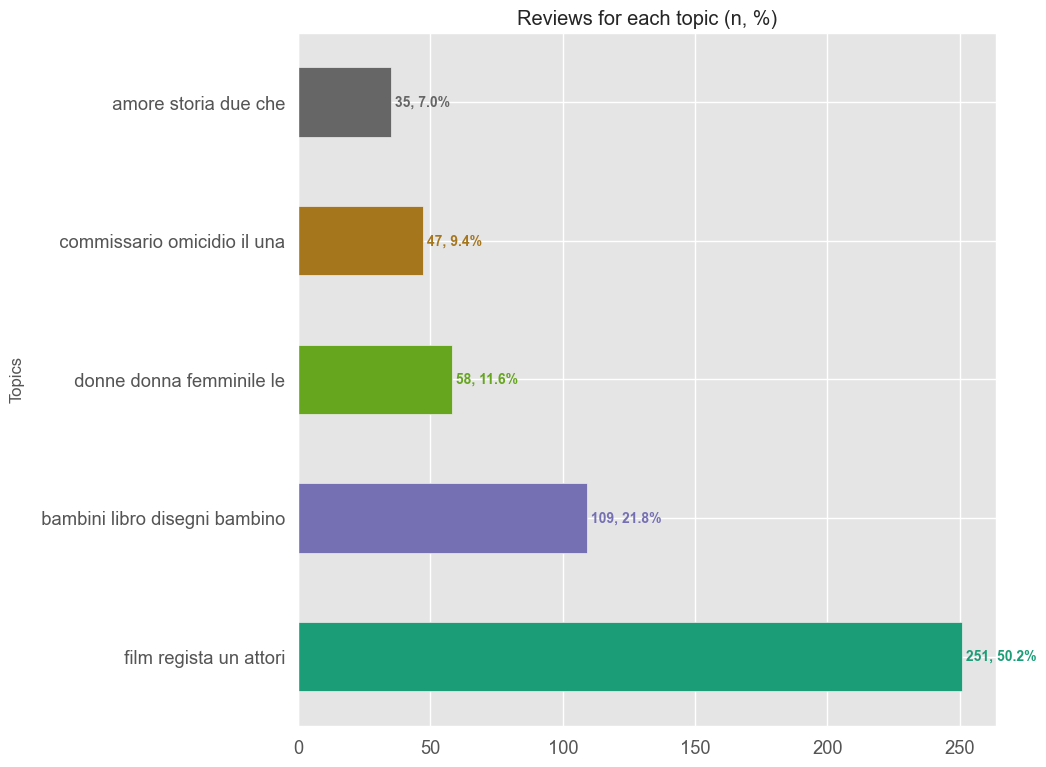

In [49]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')


num_classes = len(df_val["Topic Description"].value_counts())
colors = plt.cm.Dark2(np.linspace(0, 1, num_classes))
iter_color = iter(colors)

df_val['Topic Description'].value_counts().plot.barh(title="Reviews for each topic (n, %)", 
                                                 ylabel="Topics",
                                                 color=colors,
                                                 figsize=(9,9))

for i, v in enumerate(df_val['Topic Description'].value_counts()):
    c = next(iter_color)
    plt.text(v, i,
           " "+str(v)+", "+str(round(v*100/df_val.shape[0],2))+"%", 
           color=c, 
           va='center', 
           fontweight='bold')

In [50]:
print_rand_example(df_val, "Labels", 1)


Original
Molto istruttivo per introdurre i bambini, in  modo divertente, ad una cultura alimentare oltre che agli oggetti del quotidiano stimolando la curiosità dei più piccoli anche grazie...

Translation
Very instructive to introduce children, in a fun way, to a food culture as well as everyday objects, stimulating the curiosity of the little ones thanks to beautiful graphics....


In [61]:
print_rand_example(df_val, "Labels", 3)


Original
Tre spari nella nebbia a Milano, per compiere un omicidio apparentemente inspiegabile; con  l’unica certezza, anche questa apparente, che una testimone abbia visto in faccia l’assa...

Translation
QUERY LENGTH LIMIT EXCEEDED. MAX ALLOWED QUERY : 500 CHARS QUERY LENGTH LIMIT EXCEEDED. MAX ALLOWED QUERY : 500 CHARS QUERY LENGTH LIMIT EXCEEDED. MAX ALLOWED QUERY : 500 CHARS QUE...


In [76]:
from sklearn.metrics import classification_report

y_pred = predict_class(df_val["Text"])
print(y_pred[20:30])
y_pred_labels = [label for _, label in y_pred]
print(y_pred_labels[20:30])
# The classification_report() function expects y_pred to be a 1-dimensional array-like object where each element corresponds to a predicted class label. Therefore, you need to extract the predicted class labels from y_pred before passing it to classification_report().
print(df_val["Labels"][20:30])
print(classification_report(df_val["Labels"], y_pred_labels))

# y_pred = predict_class(df_val["Text"])
# print(classification_report(df_val["Labels"], y_pred))

16/16 [==============================] - 5s 316ms/step
[(array([0.20259523, 0.01174911, 0.33517796, 0.43544254, 0.0150352 ],
      dtype=float32), 3), (array([0.07541276, 0.00339546, 0.9122292 , 0.0026816 , 0.00628091],
      dtype=float32), 2), (array([0.09877407, 0.00559515, 0.872321  , 0.0022315 , 0.02107821],
      dtype=float32), 2), (array([2.3658786e-04, 1.4980639e-04, 9.9894661e-01, 8.7835986e-05,
       5.7904754e-04], dtype=float32), 2), (array([1.2816157e-03, 1.5486195e-04, 9.9680781e-01, 1.2504136e-03,
       5.0526281e-04], dtype=float32), 2), (array([5.5753305e-03, 2.9895417e-03, 9.8159331e-01, 7.4770988e-04,
       9.0941060e-03], dtype=float32), 2), (array([0.39899004, 0.18162745, 0.3461723 , 0.04019671, 0.03301354],
      dtype=float32), 0), (array([7.7052013e-04, 3.9359913e-04, 9.9659914e-01, 5.5060996e-04,
       1.6860593e-03], dtype=float32), 2), (array([0.00315305, 0.00270117, 0.99151176, 0.00126428, 0.0013698 ],
      dtype=float32), 2), (array([0.0093646 , 0.007

In [82]:
model.save(r"G:\My Drive\Ingegneria\Data Science GD\Models\NLP\BERT Multiclass TF\text_classifier_v1")

INFO:tensorflow:Assets written to: G:\My Drive\Ingegneria\Data Science GD\Models\NLP\BERT Multiclass TF\text_classifier_v1\assets


INFO:tensorflow:Assets written to: G:\My Drive\Ingegneria\Data Science GD\Models\NLP\BERT Multiclass TF\text_classifier_v1\assets


In [83]:
from tensorflow import keras

# load model
new_model = keras.models.load_model(r"G:\My Drive\Ingegneria\Data Science GD\Models\NLP\BERT Multiclass TF\text_classifier_v1")

# test predictions
[np.argmax(pred) for pred in new_model.predict(reviews)]
# output: [3, 1, 0]

ValueError: Unable to restore custom object of type _tf_keras_metric. Please make sure that any custom layers are included in the `custom_objects` arg when calling `load_model()` and make sure that all layers implement `get_config` and `from_config`.